<a href="https://colab.research.google.com/github/patrickzoechbauer/TarNet/blob/main/Zero_inflated_poisson_simulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import argparse
import os
import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.special import expit, logit

import jax.numpy as jnp
from jax.random import PRNGKey
import jax.scipy as jsp

!pip install numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

     |████████████████████████████████| 283 kB 4.0 MB/s 


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
  
set_seed(0)

**Explanation:**

This example is inspired by the [fishing-data set](https://num.pyro.ai/en/latest/examples/zero_inflated_poisson.html). However, I used simulated data so that it is possible to compare the posterior estimates of MCMC and ADVI with the ground truth. 

**Findings:**

The example demonstrates that the posterior distribution from VI has lower variance compared to MCMC.



---


**Data generation:** The data generating process is given by: 

\begin{align*}
b_1 &= (0, -1.1, 0.8, -1.2, 2.1) \\
b_2 &= (0.5, 0.1, 0, 0.3, -0.7)\\
X_i^j &\sim \text{Binomal}(2, 0.7) \quad \text{for } i=1,...,n, j=1,...,3\\
X_i^4 &= 1 \text{ (intercept)} \\
ɛ_i &\sim \mathcal{N}(0, \sigma_\lambda) \quad \text{for } i=1,...,n\\
\lambda(X_i) &= \exp(X_i b_2 + ɛ_i) \\
\delta_i &\sim \mathcal{N}(0, \sigma_\pi) \quad \text{for } i=1,...,n\\
\pi(X_i) &= \text{logit}^{-1}(X_i b_1+\delta_i) \\
N_i &\sim \text{Pois}(\lambda(X_i)) \\
B_i &\sim \text{Bernoulli}(\pi(X_i)) \\
Y_i &= N_i B_i
\end{align*}


In [4]:
def simulate_data(num_samples=200, sigma_lam=1, sigma_pi=1):
  b1 = np.array([0, -1.1, 0.8, -1.2, 2.1]).reshape(1,-1)
  b2 = np.array([0.5, 0.1, 0, 0.3, -0.7]).reshape(1,-1)
  dims = b1.shape[1]-1

  #X = np.random.randn(num_samples, dims).astype(np.float64)
  X = np.random.binomial(2, 0.7, size = (num_samples, dims)).astype(np.float64)
  #Add intercept for X
  X = np.c_[ X, np.ones(num_samples) ]  

  #Simulate lambda
  #b2 = 0.5*np.random.randn(1,dims+1).astype(np.float64)
  noise = np.random.normal(0, sigma_lam, num_samples).astype(np.float64).reshape(-1,1)
  log_lambda = np.matmul(X, b2.T) + noise #+ mu_lambda
  #print(np.mean(np.exp(log_lambda)))

  #draw from poisson: 
  pois_draws = np.random.poisson(lam = np.exp(log_lambda))

  #Simulate pi
  #b1 = np.random.randn(1,dims+1).astype(np.float64)
  noise = np.random.normal(0, sigma_pi, num_samples).astype(np.float64).reshape(-1,1)
  logit_pi = np.matmul(X, b1.T) + noise #+ mu_pi

  #draw from bernoulli
  bernoulli_draws = np.random.binomial(1, 1-expit(logit_pi))
  #print(np.mean(1-expit(logit_pi)))

  #zero-flated poisson
  y = pois_draws*bernoulli_draws

  cols = ["var"+str(i+1) for i in range(dims)]
  cols.append("intercept")
  
  return X, y.squeeze(), b1, b2, cols

In [5]:
#Simulate data and split in train and test
X, y, b1, b2, cols = simulate_data()

mask = np.random.randn(len(y)) < 0.8
X_train = X[mask,:]
X_test = X[~mask,:]
y_train = y[mask]
y_test = y[~mask]

In [6]:
# Define bayesian model
def model(X, Y):
    D_X = X.shape[1]
    b1 = numpyro.sample("b1", dist.Normal(0.0, 1.0).expand([D_X]).to_event(1))
    b2 = numpyro.sample("b2", dist.Normal(0.0, 1.0).expand([D_X]).to_event(1))

    pi = jsp.special.expit(jnp.dot(X, b1[:, None])).reshape(-1) # logistic regression 
    
    lam = jnp.exp(jnp.dot(X, b2[:, None]).reshape(-1))

    with numpyro.plate("obs", X.shape[0]):
        numpyro.sample("Y", dist.ZeroInflatedPoisson(gate=pi, rate=lam), obs=Y)

In [7]:
# Function to run MCMC with NUTS sampler
def run_mcmc(model, num_warmup, num_samples, num_chains, X, Y):
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
    )
    mcmc.run(PRNGKey(1), X, Y)
    mcmc.print_summary()
    return mcmc.get_samples()

In [8]:
# Function to run ADVI with mean-field approximation
def run_ADVI(model, guide_family, maxiter, X, Y):
    if guide_family == "AutoDelta":
        guide = autoguide.AutoDelta(model)
    elif guide_family == "AutoDiagonalNormal":
        guide = autoguide.AutoDiagonalNormal(model)

    optimizer = numpyro.optim.Adam(0.001)
    svi = SVI(model, guide, optimizer, Trace_ELBO())
    svi_results = svi.run(PRNGKey(1), maxiter, X=X, Y=Y)
    params = svi_results.params

    return params, guide

In [9]:
# Run both VI and MCMC
print("run VI.")
vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 30000, X_train, y_train)

print("run MCMC.")
num_warmups = 2000
num_samples = 2000
num_chains = 1
posterior_samples = run_mcmc(model, num_warmups,
                             num_samples, num_chains,
                             X_train, y_train)

run VI.


100%|██████████| 30000/30000 [00:14<00:00, 2065.17it/s, init loss: 1313.4320, avg. loss [28501-30000]: 341.5468]


run MCMC.


sample: 100%|██████████| 4000/4000 [00:08<00:00, 478.74it/s, 31 steps of size 1.16e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]      0.16      0.31      0.15     -0.36      0.64   1480.89      1.00
     b1[1]     -0.91      0.28     -0.91     -1.41     -0.48   2149.49      1.00
     b1[2]      0.43      0.27      0.42      0.00      0.90   2228.83      1.00
     b1[3]     -0.47      0.26     -0.47     -0.89     -0.02   2157.70      1.00
     b1[4]      1.42      0.68      1.42      0.32      2.52   1333.99      1.00
     b2[0]      1.01      0.14      1.01      0.77      1.23   1363.23      1.00
     b2[1]     -0.29      0.10     -0.30     -0.47     -0.15   2647.12      1.00
     b2[2]     -0.14      0.09     -0.14     -0.29      0.00   2869.89      1.00
     b2[3]      0.24      0.11      0.24      0.06      0.42   2076.38      1.00
     b2[4]      0.13      0.34      0.13     -0.40      0.72   1322.45      1.00

Number of divergences: 0


In [10]:
# Evaluate prediction:
def svi_predict(model, guide, params, num_samples, X):
    predictive = Predictive(
            model=model, guide=guide, params=params, num_samples=num_samples
    )
    predictions = predictive(PRNGKey(1), X=X, Y=None)
    svi_predictions = jnp.rint(predictions["Y"].mean(0))
    return svi_predictions

vi_predictions = svi_predict(model, vi_guide, vi_params, num_samples, X_test)

predictive = Predictive(model, posterior_samples=posterior_samples)
predictions = predictive(PRNGKey(1), X=X_test, Y=None)
mcmc_predictions = jnp.rint(predictions["Y"].mean(0))

print("VI RMSE: {}".format(mean_squared_error(y_test, 
                                              vi_predictions.to_py(), 
                                              squared=False)))

print("MCMC RMSE: {}".format(mean_squared_error(y_test,
                                                 mcmc_predictions.to_py(),
                                                 squared=False)))

VI RMSE: 2.4790791301072526
MCMC RMSE: 2.4916527312876755


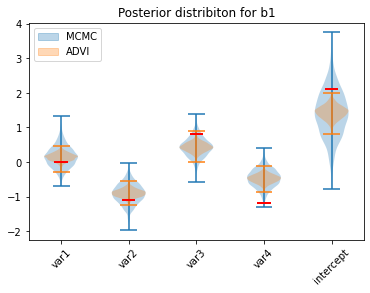

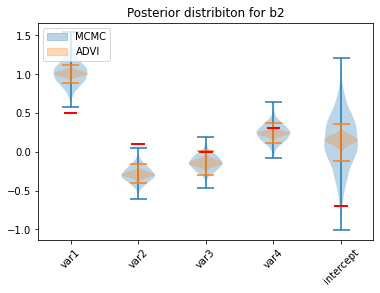

In [11]:
# Plot posterior distriutions against ground truth

def plotResults(varname):
  samples_mcmc = posterior_samples[varname]
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))[varname]

  fig, ax = plt.subplots()
  labels = []

  v1 = ax.violinplot(
      [samples_mcmc[:, i].to_py() for i in range(len(cols))]
      )
  c1 = v1['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c1), 'MCMC'))

  v2 = ax.violinplot(
      [samples_vi[:, i].to_py() for i in range(len(cols))]
      )
  c2 = v2['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c2), 'ADVI'))

  #add ground truth
  for i in range(len(cols)):
    ax.hlines(y=eval(varname).squeeze()[i], xmin=(i+1)-0.1, xmax=(i+1)+0.1, linewidth=2, color='r')

  ax.set_xticks(np.arange(1, len(cols) + 1))
  ax.set_xticklabels(cols, rotation=45, fontsize=10)
  ax.legend(*zip(*labels), loc=2)
  plt.title("Posterior distribiton for "+varname)

plotResults("b1")
plotResults("b2")